In [1]:
!pip install --user ftfy regex tqdm

     |████████████████████████████████| 53 kB 1.3 MB/s eta 0:00:011
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
!pip install --user git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /run/nvme/job_16581358/tmp/pip-req-build-ueho96d4
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369396 sha256=9d3ea71d0fac3d71a211dff57ce5b362ae00e025bbe20e04bbd8c4dc48a262d2
  Stored in directory: /run/nvme/job_16581358/tmp/pip-ephem-wheel-cache-sdkecqfc/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# as the CLIP is installed in your own directory, make sure the folder are in your path, please, change accordingly

import sys
sys.path.append("/users/vesalaia/.local/lib/python3.9/site-packages/bin")
sys.path.append("/users/vesalaia/.local/lib/python3.9/site-packages")
sys.path.append("/users/vesalaia/.local/lib/python3.9/site-packages/lib/python3.9/site-packages")
sys.path.append("/users/vesalaia/.local/lib/python3.9/site-packages/lib/python3.9/site-packages/bin")

In [2]:
import sys
sys.path
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# some pre-defined categories for images

categories = ["tools", "mathematics", "astronomy", "plant", "architecture", "animal", "human anatomy",
              "person", "bird", "map", "building"]

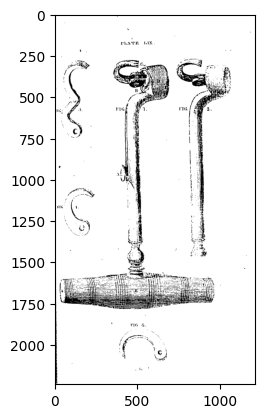

Label probs: tools [[0.2421   0.03433  0.0612   0.169    0.0371   0.02983  0.03952  0.1945
  0.1108   0.0727   0.009094]]


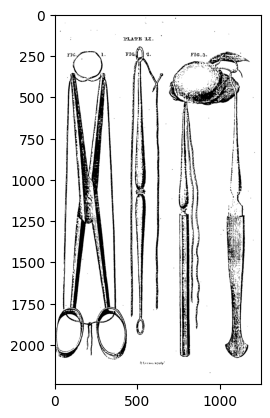

Label probs: tools [[0.749    0.003693 0.006897 0.1343   0.004593 0.02092  0.0319   0.02771
  0.01372  0.004967 0.00242 ]]


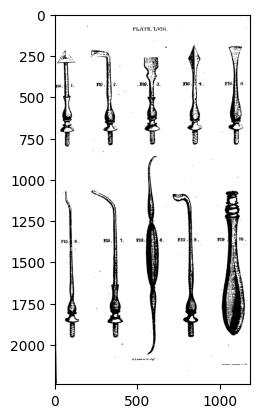

Label probs: tools [[9.243e-01 3.860e-04 2.401e-03 2.542e-02 5.441e-04 1.146e-02 2.748e-02
  4.021e-03 2.291e-03 9.851e-04 5.274e-04]]


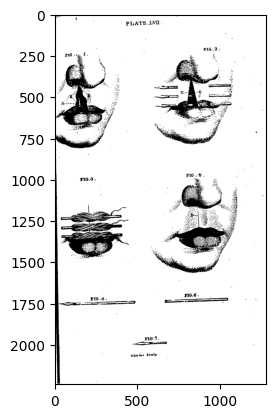

Label probs: tools [[0.264   0.04047 0.05115 0.06073 0.01106 0.02914 0.0955  0.2087  0.078
  0.155   0.0064 ]]


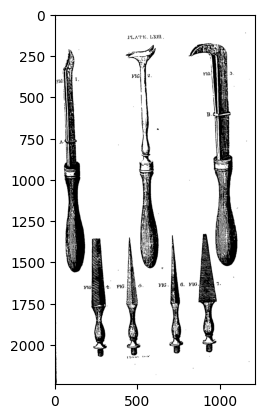

Label probs: tools [[9.902e-01 1.645e-04 4.988e-04 2.378e-03 4.864e-05 1.073e-03 3.685e-03
  1.466e-03 8.535e-05 1.261e-04 9.084e-05]]


In [3]:
# folder for images you want to classify

dir_path = "/scratch/project_2005488/DHH23/Test"

for filename in os.listdir(dir_path):
    file_path = os.path.join(dir_path, filename)
    image = preprocess(Image.open(file_path)).unsqueeze(0).to(device)
    plt.imshow(Image.open(file_path))
    plt.show()
    text = clip.tokenize(categories).to(device)

    with torch.no_grad():
     
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
    
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    print("Label probs:", categories[np.argmax(probs)], probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
    

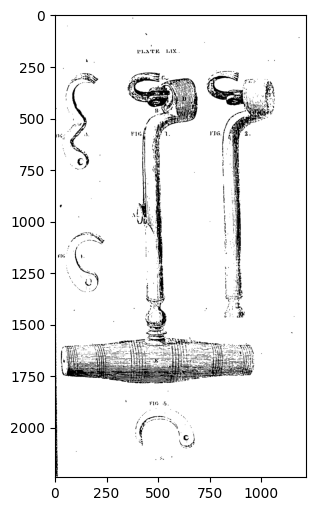

Top predictions:
           tools: 39.23%
       astronomy: 13.77%
     mathematics: 11.24%
             map: 10.72%
          person: 6.40%


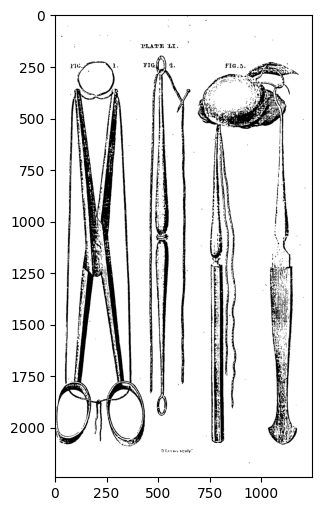

Top predictions:
           tools: 93.41%
   human anatomy: 2.30%
          animal: 1.19%
           plant: 0.93%
          person: 0.64%


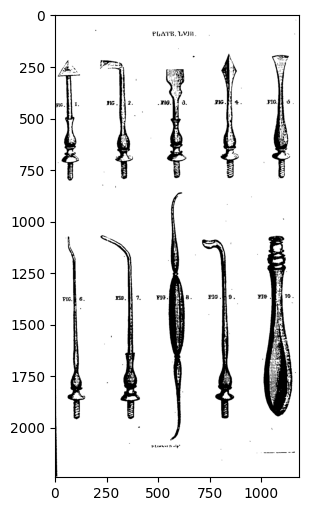

Top predictions:
           tools: 97.85%
   human anatomy: 1.21%
          animal: 0.50%
       astronomy: 0.14%
           plant: 0.10%


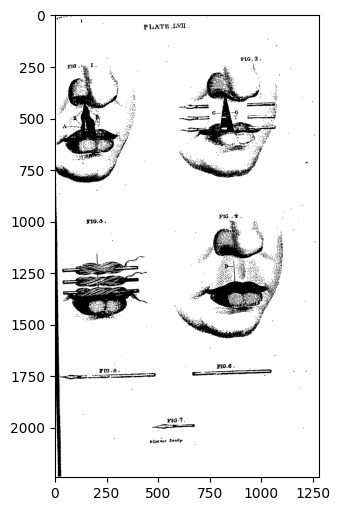

Top predictions:
           tools: 33.47%
             map: 17.37%
     mathematics: 13.53%
          person: 11.39%
       astronomy: 9.89%


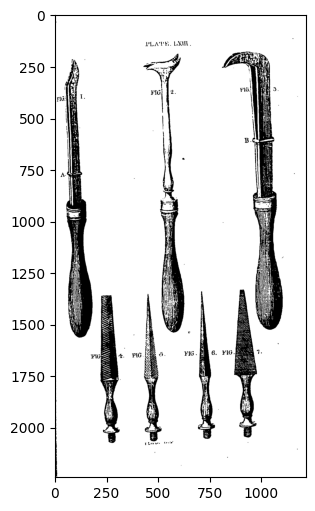

Top predictions:
           tools: 99.71%
   human anatomy: 0.17%
          animal: 0.03%
          person: 0.03%
       astronomy: 0.02%


In [4]:
model, preprocess = clip.load("ViT-B/32", device=device)

categories = ["tools", "mathematics", "astronomy", "plant", "architecture", "animal", "human anatomy",
              "person", "bird", "map", "building"]

dir_path = "/scratch/project_2005488/DHH23/Test"

text_descriptions = [f"This is a photo of a {label}" for label in categories]
text_tokens = clip.tokenize(text_descriptions).cuda()
     
for filename in os.listdir(dir_path):
    file_path = os.path.join(dir_path, filename)
    image = preprocess(Image.open(file_path)).unsqueeze(0).to(device)
    plt.figure(figsize=(10,6))
    plt.imshow(Image.open(file_path))
    plt.show()
    text = torch.cat([clip.tokenize(f"a photo of a {c}") for c in categories]).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

# Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)

# Print the result
    print("Top predictions:")
    for value, index in zip(values, indices):
        print(f"{categories[index]:>16s}: {100 * value.item():.2f}%")
